In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import glob
import os

from sklearn.model_selection import train_test_split
import shutil

from PIL import Image
%matplotlib inline

## Reading and preprocessing

In [2]:
ROOT_PATH = 'sample_dataset_for_testing/fullsampledata'

In [3]:
subset_masks = os.listdir(ROOT_PATH)

In [4]:
# traversing through all directories and making list of files

patients_id = []
CT_slice = {}

p_list, im_list, path_list = [], [], []

for sm in subset_masks:
    patients = os.listdir(ROOT_PATH + '/' + sm)
    for patient in patients:
        CT_slice[patient] = os.listdir(ROOT_PATH + '/' + sm + '/' + patient)
        patients_id.append(patient)
        
        for image in CT_slice[patient]:
            im_list.append(image)
            p_list.append(patient)
            path_list.append(ROOT_PATH + '/' + sm + '/' + patient + '/' + image)

In [5]:
# making a dataframe out of all the data

df = pd.DataFrame({'patient': p_list, 'image':im_list, 'image_path': path_list})
df.head()

,patient,image,image_path
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,0.tiff,sample_dataset_for_testing/fullsampledata/subs...
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,1.tiff,sample_dataset_for_testing/fullsampledata/subs...
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,10.tiff,sample_dataset_for_testing/fullsampledata/subs...
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,100.tiff,sample_dataset_for_testing/fullsampledata/subs...
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,101.tiff,sample_dataset_for_testing/fullsampledata/subs...


In [6]:
# dataframe having only images

image_df = df[df['image'].str.contains('_mask')==False]
image_df.head()

,patient,image,image_path
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,0.tiff,sample_dataset_for_testing/fullsampledata/subs...
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,1.tiff,sample_dataset_for_testing/fullsampledata/subs...
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,10.tiff,sample_dataset_for_testing/fullsampledata/subs...
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,100.tiff,sample_dataset_for_testing/fullsampledata/subs...
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,101.tiff,sample_dataset_for_testing/fullsampledata/subs...


In [7]:
# dataframe having only masks

mask_df = df[df['image'].str.contains('_mask')==True]

mask_df =mask_df.copy()
mask_df['mask'] = mask_df['image']

mask_df['image'] = mask_df['image'].str.split('_', n = 1, expand = True)
mask_df['image'] = mask_df['image'].astype(str) + '.tiff'

mask_df = mask_df.rename(index=str, columns={'image_path':'mask_path'})

mask_df.head()

,patient,image,mask_path,mask
578,1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896...,79.tiff,sample_dataset_for_testing/fullsampledata/subs...,79_mask.tiff
581,1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896...,80.tiff,sample_dataset_for_testing/fullsampledata/subs...,80_mask.tiff
583,1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896...,81.tiff,sample_dataset_for_testing/fullsampledata/subs...,81_mask.tiff
585,1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896...,82.tiff,sample_dataset_for_testing/fullsampledata/subs...,82_mask.tiff
587,1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896...,83.tiff,sample_dataset_for_testing/fullsampledata/subs...,83_mask.tiff


In [8]:
# dividing the images into two groups, one having abnormality and the other normal

abnormal = []
normal = []

for index, row in image_df.iterrows():
    flag = True
    for (patient, image) in zip(mask_df['patient'].values, mask_df['image'].values):
        if(row['patient']==patient and row['image']==image):
            abnormal.append(row['image_path'])
            flag = False
    if(flag):
        normal.append(row['image_path'])
        
abnormal = np.asarray(abnormal)
normal = np.asarray(normal)

In [9]:
# getting all the masks from images having abnormality

abnormal_masks = mask_df['mask_path'].values

In [10]:
# checking the number of images having abnormality 

len(abnormal), len(abnormal_masks), len(normal)

(62, 62, 3074)

In [11]:
# creating a dictionary of image masks corresponding to images having abnormality, to be used later

image_mask_pair = dict(zip(abnormal, abnormal_masks))

In [12]:
# making a dataframe out of both arrays to use it for splitting b/w train and test

abn_df = pd.DataFrame({'X':abnormal})
abn_df['Y'] = 1

n_df = pd.DataFrame({'X':normal})
n_df['Y'] = 0

In [13]:
df = pd.concat([abn_df, n_df])

# shuffling the dataset
df = df.sample(frac=1).reset_index(drop=True)

In [14]:
# splitting the images into train validation and test
# using stratify to make sure the images in both set are present in same proportion as classes

X_train, X_test, Y_train, Y_test = train_test_split(df.X.values, df.Y.values, test_size=0.2, stratify=df.Y.values, random_state=0)

X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.5, stratify=Y_test, random_state=0)

In [15]:
print('No. of images in train: {} \nNo. of images in validation: {} \nNo. of images in test: {}'.format(
                                                            X_train.shape[0], X_val.shape[0], X_test.shape[0]))

No. of images in train: 2508 
No. of images in validation: 314 
No. of images in test: 314


In [16]:
# clearing the memory

df = None
image_df = None
mask_df = None
abn_df = None
n_df = None

## Dataset preparation

We only have maps for images with abnormality and the number of such images is very less. Our objective is to localize abnormality in the CT scan images and hence if there is no abnormality detected, the segmented mask of the image with no abnormality would be blank or a 512 x 512 black image in case of our data.

Therefore to make the training simpler we create masks for all the normal images. 

*Although this introduces a lot of bias in the dataset towards the `normal` class as majority of the images belong to `normal`. We can try to increase the number of images having abnormality using data augmetation.*

In [17]:
# function to prepare masks for normal images
# note that we do not need masks for every image, as all normal images will have the same mask

def create_normal_masks(path):
        width, height = (512, 512) #image.size
        mask = np.zeros((width, height))
        
        Image.fromarray(mask).save(path+'normal_mask.tiff')

In [18]:
# making the train directory with the preprocessed data

if(not os.path.isdir('preprocessed_data/')):

    n_destination = 'preprocessed_data/train/normal/'
    abn_destination = 'preprocessed_data/train/abnormal/'

    if(not os.path.isdir(n_destination)):
        os.makedirs(n_destination)
    if(not os.path.isdir(abn_destination)):
        os.makedirs(abn_destination)

    create_normal_masks(n_destination) # creating a single mask for images with no abnormality

    for path, y in zip(X_train, Y_train):
        patient_id = path.split('/')[3]
        image_id = path.split('/')[4]

        if(y==0):
            shutil.copy(path, n_destination+patient_id+'_'+image_id) # if class is normal
        else:
            shutil.copy(path, abn_destination+patient_id+'_'+image_id) # if class is abnormal
            shutil.copy(image_mask_pair[path], abn_destination+patient_id+'_'+image_mask_pair[path].split('/')[4])


    # making the validation directory with the preprocessed data

    n_destination = 'preprocessed_data/validation/normal/'
    abn_destination = 'preprocessed_data/validation/abnormal/'

    if(not os.path.isdir(n_destination)):
        os.makedirs(n_destination)
    if(not os.path.isdir(abn_destination)):
        os.makedirs(abn_destination)

    create_normal_masks(n_destination)

    for path, y in zip(X_val, Y_val):
        patient_id = path.split('/')[3]
        image_id = path.split('/')[4]

        if(y==0):
            shutil.copy(path, n_destination+patient_id+'_'+image_id)
        else:
            shutil.copy(path, abn_destination+patient_id+'_'+image_id)
            shutil.copy(image_mask_pair[path], abn_destination+patient_id+'_'+image_mask_pair[path].split('/')[4])


    # making the validation directory with the preprocessed data        

    n_destination = 'preprocessed_data/test/normal/'
    abn_destination = 'preprocessed_data/test/abnormal/'

    if(not os.path.isdir(n_destination)):
        os.makedirs(n_destination)
    if(not os.path.isdir(abn_destination)):
        os.makedirs(abn_destination)

    for path, y in zip(X_test, Y_test):
        patient_id = path.split('/')[3]
        image_id = path.split('/')[4]

        if(y==0):
            shutil.copy(path, n_destination+patient_id+'_'+image_id)
        else:
            shutil.copy(path, abn_destination+patient_id+'_'+image_id)

else:
    pass # if preprocessed data already present skip this process

(512, 512)


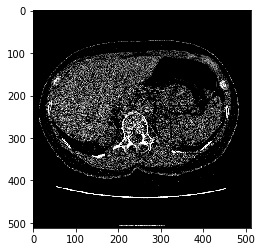

In [19]:
# visualising a CT scan slice

im_path = 'preprocessed_data/train/normal/1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720_28.tiff'

im = Image.open(im_path).convert('RGB')
print(im.size)
plt.imshow(im)

## Data augmentation

In [20]:
def rotation(image, degree=10):
    # rotation
    return image.rotate(degree)

def horizontal_flip(image):
    # horizontal flip 
    return image.transpose(Image.FLIP_LEFT_RIGHT)

In [21]:
def data_augment(path):
    images = os.listdir(path)
    
    if(len(glob.glob(path+'*_rotated.tiff'))==0): # if the augmented data is not already cached in storage
        for image in images:
            original_image = Image.open(os.path.join(path, image))

            rotated_image = rotation(original_image)
            if('mask' in image):
                rotated_image.save(os.path.join(path, image[:-10])+'_rotated_mask.tiff')
            else:
                rotated_image.save(os.path.join(path, image[:-5])+'_rotated.tiff')

            flipped_image = horizontal_flip(original_image)
            if('mask' in image):
                flipped_image.save(os.path.join(path, image[:-10])+'_flipped_mask.tiff')
            else:
                flipped_image.save(os.path.join(path, image[:-5])+'_flipped.tiff')
        
    
    return int(len(images)) # images/2 + images/2, divided by 2 because mask are also present

In [22]:
train_added = data_augment('preprocessed_data/train/abnormal/')
val_added = data_augment('preprocessed_data/validation/abnormal/')

In [24]:
print('No. of images in train: {} \nNo. of images in validation: {}'.format(
                                                            X_train.shape[0]+train_added, X_val.shape[0]+val_added))

No. of images in train: 2608 
No. of images in validation: 326


## Data Loading

In [25]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchsummary import summary

from scipy.ndimage import imread

from model import Net

In [26]:
# function to return images and corresponding masks that will act like ground truths/targets for the model

def make_dataset(root='preprocessed_data', train=True):
    dataset = []

    if train:
        dir = os.path.join(root, 'train')
    else:
        dir = os.path.join(root, 'validation')

    for fGT in glob.glob(os.path.join(dir+'/abnormal/', '*_mask.tiff')):
        fName = os.path.basename(fGT)
        fImg = fName[:-10] + '.tiff'
        
        dataset.append( [os.path.join(dir+'/abnormal/', fImg), os.path.join(dir+'/abnormal/', fName)] )
        
    for fImg in glob.glob(os.path.join(dir+'/normal/', '*.tiff')):
        fName = 'normal_mask.tiff'

        dataset.append( [os.path.join(fImg), os.path.join(dir+'/normal/', fName)] )

    return dataset

In [27]:
# custom Dataset class that is used by the DataLoader to load data into the input pipeline

class CTScanSlides(Dataset):
    
    def __init__(self, root, transform=None, train=True):
        self.train = train

        self.set_path = make_dataset(root, self.train)

    def __getitem__(self, idx):
        img_path, gt_path = self.set_path[idx]

        img = Image.open(img_path).convert('RGB').convert('L') #converting so that values are b/w 0-255
        img = np.array(img).reshape(-1, 512, 512)
        img = img/255
        img = torch.from_numpy(img).float()

        gt = Image.open(gt_path).convert('RGB').convert('L')
        gt = np.array(gt).reshape(-1, 512, 512)
        gt = gt/255
        gt = torch.from_numpy(gt).float()

        return img, gt

    def __len__(self):
        if self.train:
            return 2608
        else:
            return 326

In [28]:
# hyperparameters

batchSize = 2 # very-small batch size to avoid out of memory issues
learning_rate = 0.0002

In [29]:
# making the training device agnostic

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [30]:
# dataloaders for training and validation

train_data = CTScanSlides('preprocessed_data', train=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batchSize, shuffle=True)

val_data = CTScanSlides('preprocessed_data', train=False)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batchSize, shuffle=True)

## Model & Training

In [31]:
model = Net(useBN=True) # smaller version of standard UNet
model.to(device)

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1

In [32]:
# having a look at the model specifications

summary(model, input_size=(1, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 512, 512]             320
       BatchNorm2d-2         [-1, 32, 512, 512]              64
         LeakyReLU-3         [-1, 32, 512, 512]               0
            Conv2d-4         [-1, 32, 512, 512]           9,248
       BatchNorm2d-5         [-1, 32, 512, 512]              64
         LeakyReLU-6         [-1, 32, 512, 512]               0
         MaxPool2d-7         [-1, 32, 256, 256]               0
            Conv2d-8         [-1, 64, 256, 256]          18,496
       BatchNorm2d-9         [-1, 64, 256, 256]             128
        LeakyReLU-10         [-1, 64, 256, 256]               0
           Conv2d-11         [-1, 64, 256, 256]          36,928
      BatchNorm2d-12         [-1, 64, 256, 256]             128
        LeakyReLU-13         [-1, 64, 256, 256]               0
        MaxPool2d-14         [-1, 64, 1

In [33]:
# defining optimizer and loss function

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

In [34]:
# function containing the train loop

losses = {'train':[], 'validation':[]}

def train(n_epochs, model, optimizer, criterion, model_save_path):
    '''
    n_epochs: number of epochs the model trains for
    model: the model used for segmentation
    optimizer: the optimizer like Adam, Adagrad etc.
    criterion: the loss function used for optimizing the model
    
    Returns:
    model: : the trained model to be used for testing'''
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        
        #####----TRAINING----#####
        model.train()
        for data, target in train_loader:

            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            
            pred = model(data)
            loss = criterion(pred, target)
            
            train_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
        #####----VALIDATION----#####    
        model.eval()
        for data, target in val_loader:

            data, target = data.to(device), target.to(device)


            val_pred = model(data)
            val_loss = criterion(val_pred, target)

            valid_loss += val_loss.item()

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
        
        #####----CHECKPOINTING----#####
        if (valid_loss < valid_loss_min):
            print("Saving model.  Validation loss:... {} --> {}".format(valid_loss_min, valid_loss))
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), model_save_path)
            print()
            
        losses['train'].append(train_loss)
        losses['validation'].append(valid_loss)
        
    return model

In [35]:
unet = train(10, model, optimizer, criterion, 'model.pt')

Epoch: 1 	Training Loss: 81.115523 	Validation Loss: 0.476846
Saving model.  Validation loss:... inf --> 0.4768455671146512

Epoch: 2 	Training Loss: 1.812957 	Validation Loss: 0.148370
Saving model.  Validation loss:... 0.4768455671146512 --> 0.14837009634356946

Epoch: 3 	Training Loss: 0.692534 	Validation Loss: 0.098791
Saving model.  Validation loss:... 0.14837009634356946 --> 0.09879077502409928

Epoch: 4 	Training Loss: 0.440339 	Validation Loss: 0.091040
Saving model.  Validation loss:... 0.09879077502409928 --> 0.09103998696809867

Epoch: 5 	Training Loss: 0.362625 	Validation Loss: 0.080835
Saving model.  Validation loss:... 0.09103998696809867 --> 0.08083522547531174

Epoch: 6 	Training Loss: 0.317972 	Validation Loss: 0.084605
Epoch: 7 	Training Loss: 0.284752 	Validation Loss: 0.048879
Saving model.  Validation loss:... 0.08083522547531174 --> 0.0488787101185153

Epoch: 8 	Training Loss: 0.259161 	Validation Loss: 0.049793
Epoch: 9 	Training Loss: 0.223690 	Validation Loss

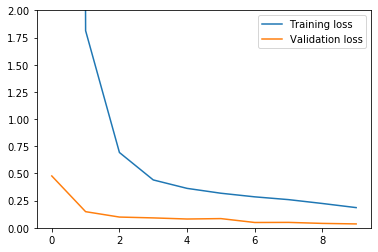

In [43]:
import matplotlib.pyplot as plt
plt.ylim([0,2])
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()

## Testing & Inference

In [37]:
# function to localize the abnormality on the CT scan plot according to the predicted mask

def generate_plot(background, overlay, ratio=0.5):
    '''
    background: original CT scan image
    overlay: mask to be superimposed over the scan
    ratio: degree of blend of original image and predicted mask'''
    
    background = background.convert("RGB")
    overlay = overlay.convert("RGB")

    pixels = overlay.load()
    
    for i in range(overlay.size[0]): # for every pixel
        for j in range(overlay.size[1]):
            if pixels[i,j] == (255, 255, 255):
                pixels[i,j] = (255, 0 , 0)

    new_img = Image.blend(background, overlay, ratio)
    
    return new_img

In [38]:
# function for testing the model

def test(path):
    '''
    path: path to the folder where test images are present
    
    Returns:
    plot with the abnormal region highlighted on the CT scan'''
    
    img_pth = os.listdir(path)
    for ipth in img_pth:
        img = imread(path+ipth)
        img = img.reshape(-1, 1, 512, 512)
        img = np.where(img > 0, 1, 0)
        img = torch.from_numpy(img).float()
        
        pred_mask = unet(img.to(device))
        pred_mask = pred_mask.detach().cpu().numpy().reshape(512,512)
        
        img = Image.open(path+ipth)
        pred_mask = Image.fromarray(pred_mask)
        
        display_img = generate_plot(img, pred_mask)
        plt.imshow(display_img)
        plt.show()

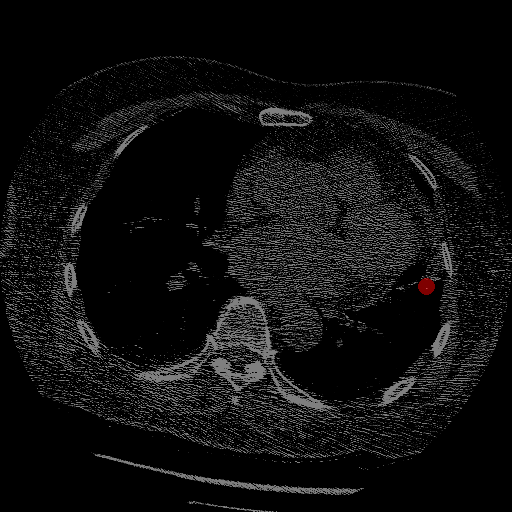

In [46]:
# NOTE: this is just an example where image and mask are explicitly taken as our trained model doesn't converge

b = Image.open('preprocessed_data/validation/abnormal/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059_80.tiff')
o = Image.open('preprocessed_data/validation/abnormal/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059_80_mask.tiff')
generate_plot(b, o, 0.5)